Import libraries

In [30]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Embedding
from sklearn.model_selection import train_test_split

## Loading dataset

In [4]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("I:\\Projects\\Imdb\\a1_IMDB_Dataset.csv")

In [5]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [6]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
# Checking for missing values

movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

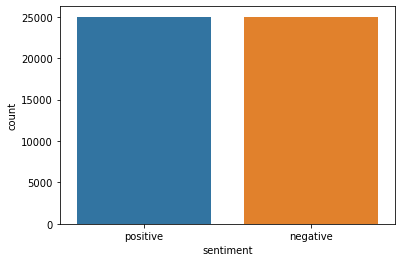

In [8]:
# Let's observe distribution of positive / negative sentiments in dataset

sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [9]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\T Yashwanth
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [14]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [15]:
# Sample cleaned up movie review 

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [16]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [18]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [20]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [21]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [24]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('I:\\Projects\\Imdb\\a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [25]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
embedding_matrix.shape

(92394, 100)

# Model Training with:

## LSTM Neural Network

In [27]:
from keras.layers import LSTM

In [31]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [32]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [33]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 39s 148ms/step - loss: 0.5069 - acc: 0.7537 - val_loss: 0.4295 - val_acc: 0.8030
Epoch 2/6
250/250 [==============================] - 41s 165ms/step - loss: 0.4118 - acc: 0.8173 - val_loss: 0.4394 - val_acc: 0.8141
Epoch 3/6
250/250 [==============================] - 43s 171ms/step - loss: 0.3830 - acc: 0.8345 - val_loss: 0.3697 - val_acc: 0.8410
Epoch 4/6
250/250 [==============================] - 43s 172ms/step - loss: 0.3443 - acc: 0.8522 - val_loss: 0.3354 - val_acc: 0.8572
Epoch 5/6
250/250 [==============================] - 43s 172ms/step - loss: 0.3194 - acc: 0.8651 - val_loss: 0.3305 - val_acc: 0.8633
Epoch 6/6
250/250 [==============================] - 44s 175ms/step - loss: 0.3071 - acc: 0.8727 - val_loss: 0.3311 - val_acc: 0.8685


In [34]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 8s 25ms/step - loss: 0.3400 - acc: 0.8631


In [35]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3400227129459381
Test Accuracy: 0.863099992275238


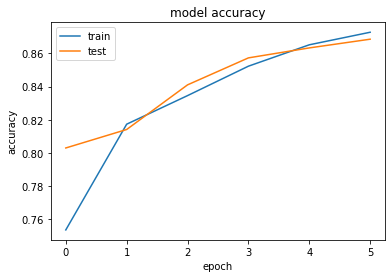

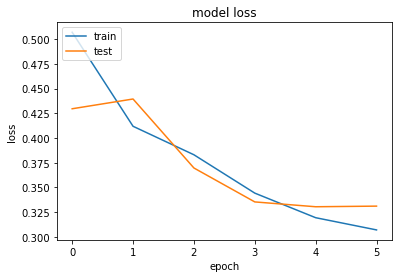

In [36]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()